In [57]:
import pden
import pden.Net
import pden.Operations
import pden.PDENet

import tensorflow as tf

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import clear_output

%load_ext autoreload
%autoreload 1

%aimport pden.Net
%aimport pden.Operations
%aimport pden.PDENet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
def der(y, x, y_shape: int, x_shape: int):
    ys = tf.split(y, [1] * y_shape, 1)
    def _der(i, j=[]):
        f = ys[i]
        for _j in j:
            fs = tf.gradients(f, x)[0]
            f  = tf.split(fs, [1] * x_shape, 1)[_j]        
        return f
    return _der

In [81]:
k = 3
net = pden.Net.BasicNet(
    pden.Operations.Linear(feature_out=k, random_init = True),
    pden.Operations.ActivationFunction(tf.nn.tanh),
    pden.Operations.Linear(feature_in=k, feature_out=1, random_init = True)
)

pnet = pden.PDENet.PDENET(net=net)
print(net)

Net 20:
	14	Linear: [1 -> 3]
	21	Activation funciton: <function tanh at 0x11ac17dd0>
	5	Linear: [3 -> 1]


In [82]:
x = tf.placeholder(tf.float64, [None, 1])
y = pnet.forward(x)

bc_x = tf.placeholder(tf.float64, [1, 1])
bc_y = pnet.forward(bc_x)

der_gen = der(y, x, 1, 1)
dy = der_gen(0, j=[0])
dy2= der_gen(0, j=[0, 0])

bc_der = der(bc_y, bc_x, 1, 1)(0, j=[0])

In [83]:
pnet = pnet.add_loss(tf.reduce_mean(tf.pow(dy2 - 2.0 * (tf.cos(tf.pow(x, 2)) - 2 * tf.sin(tf.pow(x, 2)) * tf.pow(x, 2)), 2)))
pnet = pnet.add_loss(tf.reduce_mean(tf.pow(bc_y, 2)), weight=5.0)
pnet = pnet.add_loss(tf.reduce_mean(tf.pow(bc_der, 2)), weight=5.0)

In [84]:
learning_rate = 1e-2
training_epochs = 2000
display_step = 250

opt = tf.train.AdamOptimizer(learning_rate = learning_rate)
train = opt.minimize(pnet.loss)

init = tf.global_variables_initializer()

In [85]:
X = np.linspace(0, 1, 100).reshape(-1, 1)

In [86]:
losses = []

Training error for net is "0.00279846401275701". Epoch 1750


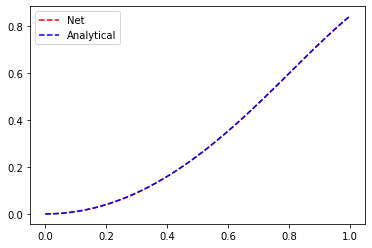

Optimization Finished!


In [87]:
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    
#     P = np.random.uniform(0, 0.5, size=(1,))
    
    _, l, Y = sess.run([train, pnet.loss, y], feed_dict={
        x: X,
        bc_x: np.array([[0.0]])
    })
    
    losses.append(l)
    
    if epoch % display_step == 0 and True:
        clear_output(wait=True)
        
        print(f'Training error for net is "{l}". Epoch {epoch}')
        
        plt.plot(X.flatten(), Y.flatten(), '--r', label='Net')
        plt.plot(X.flatten(), np.sin(X.flatten() ** 2), '--b', label='Analytical')
        plt.legend()
        plt.show()

        
print("Optimization Finished!")

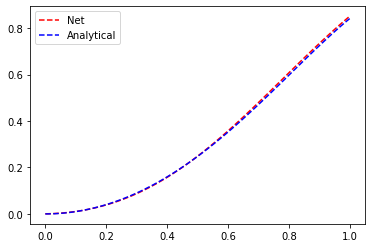

In [70]:
plt.plot(X.flatten(), Y.flatten(), '--r', label='Net')
plt.plot(X.flatten(), np.sin(X.flatten() ** 2), '--b', label='Analytical')
plt.legend()
plt.show()

In [79]:
# l_3_1 = losses

In [71]:
# l_2_1 = losses

In [88]:
# l_3_5 = losses

In [89]:
x = np.array(l_2_1[:1500])
y = np.array(l_3_1[:1500])
z = np.array(l_3_5[:1500])

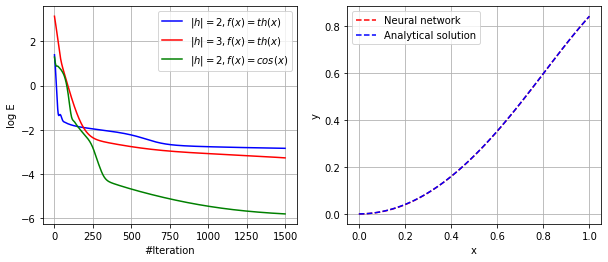

In [92]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(np.log(x), 'b', label=r'$\|h\| = 2, f(x) = th(x)$')
plt.plot(np.log(y), 'r', label=r'$\|h\| = 3, f(x) = th(x)$')
plt.plot(np.log(z), 'g', label=r'$\|h\| = 2, f(x) = cos(x)$')
plt.grid()
plt.xlabel('#Iteration')
plt.ylabel('log E')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(X.flatten(), Y.flatten(), '--r', label='Neural network')
plt.plot(X.flatten(), np.sin(X.flatten() ** 2), '--b', label='Analytical solution')
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.show()